# Reconhecimento Facial em Câmeras de Segurança aplicado em Cidades Inteligentes e Segurança Pública
Este notebook apresenta o processo de construção de um modelo de **reconhecimento facial** baseado no dataset QMUL-SurvFace.

Neste notebook, estão presentes as etapas de:

- 1. Preparação do conjunto de dados e da validação cruzada
- 2. Extração de características com FaceNet e ArcFace
- 3. Identificação facial através da comparação de embeddings

# 0. Importando bibliotecas e dependências, além de fazer device-agnostic code

Forçar a reinstalação do PyTorch para garantir compatibilidade com o cuDNN do Colab
- A flag --force-reinstall garante que as versões corretas sejam instaladas.
- O index-url aponta para o repositório oficial do PyTorch para a versão correta do CUDA.

Uma vez que ambiente for corrigido. É necessário reiniciar a sessão, sem a necessidade de executar esta célula novamente

In [ ]:
# Forçando a reinstalação do PyTorch para alinhar com o ambiente CUDA/cuDNN
!pip install --upgrade --force-reinstall torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

--- Forçando a reinstalação do PyTorch para alinhar com o ambiente CUDA/cuDNN ---

--- Instalando outras bibliotecas ---
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 74.7 MB/s eta 0:00:00

✅ Ambiente corrigido. Por favor, clique em 'RESTART SESSION' ou 'REINICIAR SESSÃO' no aviso que aparecerá na saída.
Após reiniciar, execute o restante do seu código, mas NÃO execute esta célula novamente.


In [ ]:
# Instalando outras bibliotecas
!pip install facenet-pytorch --no-deps
!pip install -U albumentationsx

In [ ]:
# Montar Google Colab para ter acesso ao dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Fri Jul  4 14:10:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   67C    P8             15W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import accuracy_score

from PIL import Image
import zipfile
import os
from pathlib import Path
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from timeit import default_timer as timer
from scipy.io import loadmat
import copy
import math

In [ ]:
print(f"Versão do PyTorch: {torch.__version__}")

Versão do PyTorch: 2.6.0+cu124


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Definir seed para reprodutibilidade
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(SEED)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

# 1. Pegar os dados


## 1.1 Definir caminhos e extrair o zip do dataset


In [ ]:
# Caminho para .zip do dataset
zip_path = '/content/drive/MyDrive/PIBIC 2024-2025/QMUL-SurvFace-v1.zip' # Verifique este caminho

# Caminho para qual iremos extrair
extract_path = Path("/content/qmul_data")

# Criar diretório e extrair
if not (extract_path / "QMUL-SurvFace").exists(): # Evitar extrair múltiplas vezes
  os.makedirs(extract_path, exist_ok=True)
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    print("Descompactando o dataset...")
    zip_ref.extractall(extract_path)
  print("Dataset extraído com sucesso.")
else:
  print("Dataset já parece estar extraído.")

# Definir o caminho base do dataset extraído
dataset_base_path = extract_path / "QMUL-SurvFace"
train_path = dataset_base_path / "training_set"
gallery_path_id_test = dataset_base_path / "Face_Identification_Test_Set" / "gallery"
probe_path_id_test = dataset_base_path / "Face_Identification_Test_Set" / "mated_probe"

Descompactando o dataset...
Dataset extraído com sucesso.


# 2. Transformar as imagens

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Tamanho da imagem
IMG_SIZE = 160

# Transformações de TREINO
train_transform = A.Compose([
    A.Resize(height=IMG_SIZE, width=IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1, p=0.8),
    A.GaussNoise(p=0.2),
    A.OneOf([
        A.MotionBlur(p=0.3),
        A.MedianBlur(blur_limit=3, p=0.2),
        A.GaussianBlur(p=0.3),
    ], p=0.5),
    A.GridDistortion(p=0.2),
    A.CoarseDropout(
        num_holes_range=(1, 8),
        hole_height_range=(8, 16),
        hole_width_range=(8, 16),
        fill=0,
        p=0.5
    ),
    A.ToFloat(max_value=255.0),
    ToTensorV2(),
])

# Transformações de VALIDAÇÃO/TESTE
val_test_transform = A.Compose([
    A.Resize(height=IMG_SIZE, width=IMG_SIZE),
    A.ToFloat(max_value=255.0),
    ToTensorV2()
])

print("Transformações definidas!")

Transformações definidas!


# 3. Criando o Datasets e DataLoaders

In [ ]:
class QMULImageDataset(Dataset):
  """Dataset personalizado para o conjunto de dados QMUL-SurvFace.

  Este dataset suporta tanto o carregamento do conjunto de treino
  (organizado em pastas por classes/IDs) quanto o de teste
  (arquivos nomeados com padrão `ID_cam_frame.jpg`).
  """

  def __init__(self, root_dir, transform=None, is_train_set=True):
    """Inicializa a instância do dataset.

    Args:
      root_dir (str or Path): Diretório raiz contendo as imagens.
      transform (albumentations.Compose, opcional): Transformações a serem aplicadas às imagens.
      is_train_set (bool, default=True): Define se o dataset é de treino (pastas por classe)
      ou de teste (arquivos individuais).
    """
    self.root_dir = Path(root_dir)
    self.transform = transform
    self.img_files = []
    self.labels = []
    self.class_names_original = [] # Nomes originais das pastas/IDs
    self.class_to_idx = {}
    self._load_data(is_train_set)

  def _load_data(self, is_train_set):
    """
    Carrega os caminhos das imagens e seus respectivos rótulos.

    Args:
      is_train_set (bool): Indica se o dataset segue a estrutura de treino
      (pastas/class_id/) ou teste (arquivos nomeados `ID_cam_frame.jpg`).

    Raises:
      FileNotFoundError: Se o diretório raiz não existir.
    """

    if not self.root_dir.exists():
      raise FileNotFoundError(f"Diretório não encontrado: {self.root_dir}")

    if is_train_set: # Estrutura: root_dir/class_id/image.jpg
      original_class_ids = sorted([d.name for d in self.root_dir.iterdir() if d.is_dir()])
      self.class_names_original = [str(id_name) for id_name in original_class_ids] # Garantir que sejam strings
      self.class_to_idx = {name: i for i, name in enumerate(self.class_names_original)}

      for class_name_original in self.class_names_original:
        class_dir = self.root_dir / class_name_original
        for img_file in class_dir.glob("*.jpg"):
          self.img_files.append(img_file)
          self.labels.append(self.class_to_idx[class_name_original])
    else: # Estrutura para teste (gallery/probe): root_dir/ID_cam_frame.jpg
      temp_labels = []
      for img_file in self.root_dir.glob("*.jpg"):
        self.img_files.append(img_file)
        # Extrai o ID da imagem do nome do arquivo
        original_id_str = img_file.name.split('_')[0]
        temp_labels.append(original_id_str)

      # Mapeia IDs originais para índices numéricos contínuos
      self.class_names_original = sorted(list(set(temp_labels)))
      self.class_to_idx = {name: i for i, name in enumerate(self.class_names_original)}
      self.labels = [self.class_to_idx[id_str] for id_str in temp_labels]

  def __len__(self):
    """
    Retorna o número total de imagens no dataset.

    Returns:
      int: Quantidade de imagens.
    """

    return len(self.img_files)

  def __getitem__(self, idx):
    """
    Recupera a imagem, rótulo e caminho do arquivo a partir do índice.

    Args:
      idx (int): Índice da amostra desejada.

    Returns:
      tuple:
        - torch.Tensor: Imagem transformada (C x H x W).
        - int: Rótulo numérico correspondente ao ID.
        - str: Caminho absoluto da imagem.
    """
    img_path = self.img_files[idx]
    label = self.labels[idx]

    # Carregue a imagem e converta para NumPy array
    img = Image.open(img_path).convert("RGB")
    img_np = np.array(img)

    # Aplique as transformações da Albumentations
    if self.transform:
      augmented = self.transform(image=img_np)
      img_tensor = augmented['image']
    else:
      # Fallback para converter para tensor se não houver transformações
      img_tensor = torch.from_numpy(img_np.transpose(2, 0, 1)).float() / 255.0

    return img_tensor, label, str(img_path)

In [ ]:
# Dividindo o train_full_dataset em treino e validação
validation_split = 0.2 # 20% para validação
dataset_size = len(train_full_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

if SEED is not None: # Shuffle antes de split para reprodutibilidade se seed está definida
  np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# 4. Determinação da Validação Cruzada

In [ ]:
from sklearn.model_selection import StratifiedKFold

# Configurações da Validação Cruzada
K_FOLDS = 5
EPOCHS_PER_FOLD = 15

# Lista para armazenar os scores de cada fold
results = {}

# Preparar o dataset completo que será dividido
full_train_dataset = QMULImageDataset(root_dir=train_path,
                                      transform=train_transform,
                                      is_train_set=True)
gallery_dataset = QMULImageDataset(root_dir=gallery_path_id_test, transform=val_test_transform, is_train_set=False)
probe_dataset = QMULImageDataset(root_dir=probe_path_id_test, transform=val_test_transform, is_train_set=False)

print(f"Total de imagens no dataset de treino completo: {len(full_train_dataset)}")
print(f"Total de imagens na galeria: {len(gallery_dataset)}")
print(f"Total de imagens na sonda: {len(probe_dataset)}")
print(f"Número de classes (identidades) no treino: {full_train_dataset.class_names_original}")
print(f"Número de classes (identidades) na galeria: {gallery_dataset.class_names_original}")

# Pegar os rótulos para a estratificação
full_train_labels = np.array(full_train_dataset.labels)

# Inicializar o K-Fold Estratificado
skf = StratifiedKFold(n_splits=K_FOLDS,
                      shuffle=True,
                      random_state=SEED)

Total de imagens no dataset de treino completo: 220888
Total de imagens na galeria: 60294
Total de imagens na sonda: 60423
Número de classes (identidades) no treino: ['100', '10000', '10001', '10004', '10005', '10006', '10008', '10009', '10010', '10011', '10012', '10014', '10015', '10016', '10017', '10018', '10019', '1002', '10020', '10023', '10025', '10026', '10027', '10030', '10031', '10032', '10033', '10034', '1004', '10043', '10045', '10046', '10047', '10048', '10049', '10050', '10051', '10054', '10056', '10057', '10062', '10063', '10064', '10065', '10067', '10069', '1007', '10070', '10075', '10076', '10078', '1008', '10081', '10083', '10084', '10085', '1009', '10092', '10095', '10096', '10098', '101', '1010', '10100', '10102', '10103', '10105', '10108', '10109', '1011', '10110', '10111', '10114', '10117', '10121', '10122', '10124', '10125', '10126', '10127', '10129', '1013', '10131', '10133', '10134', '10137', '10141', '10142', '10143', '10144', '10145', '10146', '10147', '10150',

# 5. ArcFace do modelo

In [ ]:
class ArcFace(nn.Module):
  """Classe que representa a implementação do ArcFace.
  """

  def __init__(self, in_features, out_features, s=30.0, m=0.50):
    """Implementação do cabeçalho ArcFace para classificação com margem angular.

    Args:
      in_features (int): Dimensão dos embeddings de entrada.
      out_features (int): Número de classes.
      s (float, opcional): Fator de escala aplicado aos logits (padrão: 30.0).
      m (float, opcional): Margem angular aplicada à classe correta
      (padrão: 0.50).
    """
    super(ArcFace, self).__init__()
    self.in_features = in_features
    self.out_features = out_features
    self.s = s
    self.m = m

    self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
    nn.init.xavier_uniform_(self.weight)

  def forward(self, embedding, label):
    """
    Executa a passagem direta do ArcFace.

    Args:
      embedding (torch.Tensor): Tensor de embeddings normalizados de tamanho
      (batch_size, in_features).
      label (torch.Tensor): Tensor de rótulos de classe de
      tamanho (batch_size,).

    Returns:
      torch.Tensor: Logits com margem angular aplicada,
      prontos para função de perda.
    """
    cosine = F.linear(F.normalize(embedding), F.normalize(self.weight))

    theta = torch.acos(torch.clamp(cosine, -1.0, 1.0))
    target_logit = torch.cos(theta + self.m)

    one_hot = torch.zeros(cosine.size(), device=embedding.device)
    one_hot.scatter_(1, label.view(-1, 1).long(), 1)

    output = (one_hot * target_logit) + ((1.0 - one_hot) * cosine)

    output *= self.s
    return output

In [ ]:
from facenet_pytorch import InceptionResnetV1

class FaceRecognitionModelWithArcFace(nn.Module):
  """Modelo de reconhecimento facial que utiliza InceptionResnetV1 com ArcFace.
  """

  def __init__(self, num_classes, embedding_size=512, s=30.0, m=0.5):
    """Inicizaliza o modelo

    Args:
      num_classes (int): Número de classes (rótulos/labels)
      embedding_size: Tamanho dos embeddings gerados pelo modelo (padrão: 512).
      s (float, opcional): Fator de escala aplicado aos logits (padrão: 30.0).
      m (float, opcional): Margem angular aplicada à classe correta
      (padrão: 0.50).
    """
    super(FaceRecognitionModelWithArcFace, self).__init__()

    self.backbone = InceptionResnetV1(
        pretrained='vggface2',
        classify=False,
        num_classes=None
    )

    self.head = ArcFace(
        in_features=embedding_size,
        out_features=num_classes,
        s=s,
        m=m
    )

  def forward(self, image, label):
    """Executa a passagem direta pelo modelo de reconhecimento facial

    Args:
      image (torch.Tensor): Batch da imagem, no formato (B, C, H, W).
      label (torch.Tensor): Tensor de rótulos de classe.

    Returns:
      torch.Tensor: Logits com margem angular aplicada pelo ArcFace.
    """
    embedding = self.backbone(image)

    logits = self.head(embedding, label)

    return logits

  def get_embedding(self, image):
    """
    Extrai o embedding da imagem usando apenas o backbone.
    """
    return self.backbone(image)

In [ ]:
num_classes_train = len(train_full_dataset.class_names_original)

arcface_model = FaceRecognitionModelWithArcFace(num_classes=num_classes_train).to(device)

print(f"Modelo InceptionResnetV1 (para fine-tuning) carregado em: {next(arcface_model.parameters()).device}")

# 6. Loop K Fold

In [ ]:
try:
  import torchmetrics
except:
  print("Instalando torchmetrics")
  !pip install -q torchmetrics
  import torchmetrics

from torchmetrics import Accuracy, Precision, Recall, F1Score, ConfusionMatrix

Instalando torchmetrics e mlxtend...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.6/962.6 kB 57.2 MB/s eta 0:00:00
mlxtend version 0.23.4


In [ ]:
def extract_embeddings_fn(dataloader, model, device):
  """Função responsável por extrair os embeddings de imagens

  Args:
    dataloader (torch.utils.data.Dataloader): Dataloader que contém os dados
    sobre as imagens.
    model (torch.nn.Module): Modelo que gera os embeddings a partir das imagens.
    device (torch.device): Dispositivo no qual as inferências serão executadas.
    Sendo 'cpu' ou 'cuda'

  Returns:
    tuple (np.ndarray, np.darray, list[str]):
      - embeddings (np.ndarray): Lista de embeddings normalizados.
      - labels (np.ndarray): Lista com os rótulos das amostras.
      - paths (list[str]]): Lista com os caminhos originais das imagens.

  """
  model.eval()

  embeddings_list = []
  labels_list = []
  paths_list = []

  with torch.inference_mode():
    # O loop passa por todas as imagens do dataloader
    for imgs, labels, paths in tqdm(dataloader, desc="Extraindo embeddings"):
      imgs = imgs.to(device)

      embeddings = model(imgs).cpu().numpy()

      # Armazena os resultados
      embeddings_list.append(embeddings)

      labels_list.extend(labels.cpu().numpy())

      paths_list.extend(list(paths)) # Garantir que paths seja uma lista de strings

  return np.vstack(embeddings_list), np.array(labels_list), paths_list

In [ ]:
def evaluate_identification_metrics_batched(gallery_embeds,
                                            gallery_lbls,
                                            gallery_paths,
                                            probe_embeds_full,
                                            probe_lbls_full,
                                            probe_paths_full,
                                            k_ranks=[1, 5, 10],
                                            batch_size=256): # Adicionado
                                            #batch_size para controlar o uso de
                                            #memória
  """
  Avalia métricas de identificação processando embeddings da sonda em batches
  para economizar memória.

  O método utiliza distância euclidiana entre os embeddings da galeria e
  das sondas (probes) para calcular métricas de identificação Rank-k, além de
  métricas adicionais (acurácia, precisão, recall, F1 e matriz de confusão)
  com base na predição Rank-1.

  Args:
    gallery_embeds (np.ndarray): Embeddings da galeria.
    gallery_lbls (np.ndarray): Rótulos da galeria.
    gallery_paths (list[str]): Caminhos absolutos para cada imagem da galeria.
    probe_embeds_full (np.ndarray): Embeddings das imagens de consulta.
    probe_lbls_full (np.ndarray): Rótulos das imagens de consulta.
    probe_paths_full (list[str]): Caminhos absolutos para cada imagem de
    consulta.
    k_ranks (list[int], optional): Lista de valores k para cálculo do
    Rank-k (padrão: [1, 5, 10, 20]).
    batch_size (int, optional): Número de sondas processadas por batch para reduzir
    o consumo de memória. Default é 256.

  Returns:
    tuple:
      - dict: Rank-k accuracies, no formato {k: accuracy}.
      - list[dict]: Lista de erros, onde cada item contém:
      - 'probe_path' (str): Caminho da imagem da sonda.
      - 'true_label' (int): Rótulo verdadeiro da sonda.
      - 'predicted_label' (int): Rótulo predito Rank-1.
      - 'predicted_gallery_path' (str): Caminho da imagem da galeria escolhida Rank-1.
      - 'distance' (float): Distância euclidiana entre a sonda e a predição Rank-1.
  """
  num_probes_total = len(probe_lbls_full)

  correct_at_k = {k: 0 for k in k_ranks}

  all_predicted_gallery_labels_rank1 = []

  print(f"Iniciando avaliação em batches. Tamanho do batch de probes: {batch_size}")

  for i in tqdm(range(0, num_probes_total, batch_size), desc="Processando batches de probes"):
    # Pega o batch atual de probes
    probe_embeds_batch = probe_embeds_full[i:i + batch_size]
    probe_lbls_batch = probe_lbls_full[i:i + batch_size]

    if len(probe_embeds_batch) == 0:
      continue

    # Calcula similaridade/distância para o batch atual de probes
    distances_batch = euclidean_distances(probe_embeds_batch, gallery_embeds)

    # Indices das predições ordenadas por similaridade (maior primeiro) para o batch
    sorted_pred_indices_batch = np.argsort(distances_batch, axis=1)

    current_batch_predicted_labels_rank1 = gallery_lbls[sorted_pred_indices_batch[:, 0]]
    all_predicted_gallery_labels_rank1.extend(current_batch_predicted_labels_rank1)

    # Calcula Rank-k para o batch
    for j in range(len(probe_lbls_batch)):
      probe_label = probe_lbls_batch[j]

      predicted_gallery_labels_for_probe = gallery_lbls[sorted_pred_indices_batch[j, :max(k_ranks)]]

      for k_val in k_ranks:
        if probe_label in predicted_gallery_labels_for_probe[:k_val]:
          correct_at_k[k_val] += 1

  print("Processamento em batches concluído.")

  # Calcula acurácia Rank-k final
  rank_k_accuracies = {k: count / num_probes_total for k, count in correct_at_k.items()}
  for k, acc in rank_k_accuracies.items():
    print(f"Rank-{k} Accuracy: {acc * 100:.2f}%")

  # Plotar CMC
  cmc_ranks = np.array(list(rank_k_accuracies.keys()))
  cmc_accuracies = np.array(list(rank_k_accuracies.values()))
  sort_idx = np.argsort(cmc_ranks)
  cmc_ranks, cmc_accuracies = cmc_ranks[sort_idx], cmc_accuracies[sort_idx]

  plt.figure(figsize=(8, 5))
  plt.plot(cmc_ranks, cmc_accuracies, marker='o')
  plt.title('Curva Característica Cumulativa (CMC)')
  plt.xlabel('Rank (k)')
  plt.ylabel('Taxa de Identificação Acumulada')
  plt.grid(True)
  plt.xticks(k_ranks)
  plt.ylim([0, 1.05])
  plt.show()

  if all_predicted_gallery_labels_rank1:
    y_pred_rank1_tensor = torch.tensor(all_predicted_gallery_labels_rank1)
    y_true_tensor = torch.tensor(probe_lbls_full) # Labels de todas as sondas

    num_gallery_classes = len(np.unique(gallery_lbls)) # Calcula a partir dos rótulos da galeria
    gallery_class_names_original_list = [str(i) for i in range(num_gallery_classes)]

    if num_gallery_classes > 0:
      accuracy_metric = Accuracy(task="multiclass", num_classes=num_gallery_classes, average="weighted")
      precision_metric = Precision(task="multiclass", num_classes=num_gallery_classes, average="weighted")
      recall_metric = Recall(task="multiclass", num_classes=num_gallery_classes, average="weighted")
      f1_metric = F1Score(task="multiclass", num_classes=num_gallery_classes, average="weighted")
      confmat_metric = ConfusionMatrix(task="multiclass", num_classes=num_gallery_classes)

      acc_tm = accuracy_metric(y_pred_rank1_tensor, y_true_tensor).item()
      prec_tm = precision_metric(y_pred_rank1_tensor, y_true_tensor).item()
      rec_tm = recall_metric(y_pred_rank1_tensor, y_true_tensor).item()
      f1_tm = f1_metric(y_pred_rank1_tensor, y_true_tensor).item()

      print("\nMétricas (TorchMetrics, baseadas em Rank-1, average='weighted'):")
      print(f"  Acurácia: {acc_tm:.4f}")
      print(f"  Precisão: {prec_tm:.4f}")
      print(f"  Recall:   {rec_tm:.4f}")
      print(f"  F1-score: {f1_tm:.4f}")

      cf_matrix_tm = confmat_metric(y_pred_rank1_tensor, y_true_tensor).cpu().numpy()

      if num_gallery_classes <= 20:
        plt.figure(figsize=(10, 8))
        sns.heatmap(cf_matrix_tm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=gallery_class_names_original_list[:num_gallery_classes],
                    yticklabels=gallery_class_names_original_list[:num_gallery_classes])
        plt.title("Matriz de Confusão (Rank-1 Predictions)")
        plt.xlabel("Predito")
        plt.ylabel("Verdadeiro")
        plt.show()
      else:
        print("Matriz de confusão muito grande para plotar com detalhes.")
    else:
      print("Nenhuma classe na galeria para calcular métricas adicionais.")
  else:
    print("Nenhuma predição Rank-1 coletada, métricas adicionais não calculadas.")

  rank_k_accuracies = {k: count / num_probes_total for k, count in correct_at_k.items()}

  return rank_k_accuracies

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


================== FOLD 1/5 ==================
Criando DataLoaders para o fold atual...
Inicializando novo modelo e otimizador...


  0%|          | 0.00/107M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/facenet_pytorch/models/inception_resnet_v1.py:329: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(cached_file)

Epoch 1/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 1/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 1/15 | Treino Loss: 20.0189, Treino Acc: 0.0000 | Val Loss: 17.3712, Val Acc: 0.0035
  Novo melhor modelo encontrado! Val Loss: 17.3712. Salvando estado...


Epoch 2/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 2/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 2/15 | Treino Loss: 16.6170, Treino Acc: 0.0120 | Val Loss: 14.1141, Val Acc: 0.0536
  Novo melhor modelo encontrado! Val Loss: 14.1141. Salvando estado...


Epoch 3/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 3/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 3/15 | Treino Loss: 14.0218, Treino Acc: 0.0608 | Val Loss: 11.6139, Val Acc: 0.1669
  Novo melhor modelo encontrado! Val Loss: 11.6139. Salvando estado...


Epoch 4/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 4/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 4/15 | Treino Loss: 12.0607, Treino Acc: 0.1327 | Val Loss: 9.9705, Val Acc: 0.2659
  Novo melhor modelo encontrado! Val Loss: 9.9705. Salvando estado...


Epoch 5/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 5/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 5/15 | Treino Loss: 10.6692, Treino Acc: 0.1976 | Val Loss: 8.9317, Val Acc: 0.3451
  Novo melhor modelo encontrado! Val Loss: 8.9317. Salvando estado...


Epoch 6/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 6/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 6/15 | Treino Loss: 9.6668, Treino Acc: 0.2546 | Val Loss: 8.2287, Val Acc: 0.4024
  Novo melhor modelo encontrado! Val Loss: 8.2287. Salvando estado...


Epoch 7/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 7/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 7/15 | Treino Loss: 8.9011, Treino Acc: 0.3038 | Val Loss: 7.7643, Val Acc: 0.4466
  Novo melhor modelo encontrado! Val Loss: 7.7643. Salvando estado...


Epoch 8/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 8/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 8/15 | Treino Loss: 8.3117, Treino Acc: 0.3457 | Val Loss: 7.3914, Val Acc: 0.4799
  Novo melhor modelo encontrado! Val Loss: 7.3914. Salvando estado...


Epoch 9/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 9/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 9/15 | Treino Loss: 7.7986, Treino Acc: 0.3839 | Val Loss: 7.0308, Val Acc: 0.5120
  Novo melhor modelo encontrado! Val Loss: 7.0308. Salvando estado...


Epoch 10/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 10/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 10/15 | Treino Loss: 7.3909, Treino Acc: 0.4148 | Val Loss: 6.7577, Val Acc: 0.5361
  Novo melhor modelo encontrado! Val Loss: 6.7577. Salvando estado...


Epoch 11/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 11/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 11/15 | Treino Loss: 7.0199, Treino Acc: 0.4450 | Val Loss: 6.6039, Val Acc: 0.5553
  Novo melhor modelo encontrado! Val Loss: 6.6039. Salvando estado...


Epoch 12/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 12/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 12/15 | Treino Loss: 6.6954, Treino Acc: 0.4705 | Val Loss: 6.3794, Val Acc: 0.5744
  Novo melhor modelo encontrado! Val Loss: 6.3794. Salvando estado...


Epoch 13/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 13/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 13/15 | Treino Loss: 6.3887, Treino Acc: 0.4947 | Val Loss: 6.2526, Val Acc: 0.5877
  Novo melhor modelo encontrado! Val Loss: 6.2526. Salvando estado...


Epoch 14/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 14/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 14/15 | Treino Loss: 6.1468, Treino Acc: 0.5148 | Val Loss: 6.0929, Val Acc: 0.6019
  Novo melhor modelo encontrado! Val Loss: 6.0929. Salvando estado...


Epoch 15/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 15/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 15/15 | Treino Loss: 5.9041, Treino Acc: 0.5322 | Val Loss: 6.1009, Val Acc: 0.5997

Tempo total de treinamento: 11846.696 segundos

Treinamento do Fold 1 concluído.
Melhor estado do modelo carregado para avaliação.
Salvando o state_dict do modelo fine-tuned em: models/best_model_fold_1.pth
Modelo salvo como best_model_fold_1.pth


Extraindo embeddings:   0%|          | 0/1885 [00:00<?, ?it/s]

Extraindo embeddings:   0%|          | 0/1889 [00:00<?, ?it/s]

Shape dos embeddings da galeria: (60294, 512)
Shape dos embeddings da probe: (60423, 512)
Iniciando avaliação em batches. Tamanho do batch de probes: 256


Processando batches de probes:   0%|          | 0/237 [00:00<?, ?it/s]

Processamento em batches concluído.
Rank-1 Accuracy: 23.90%
Rank-5 Accuracy: 34.90%
Rank-10 Accuracy: 39.62%
Rank-20 Accuracy: 44.78%


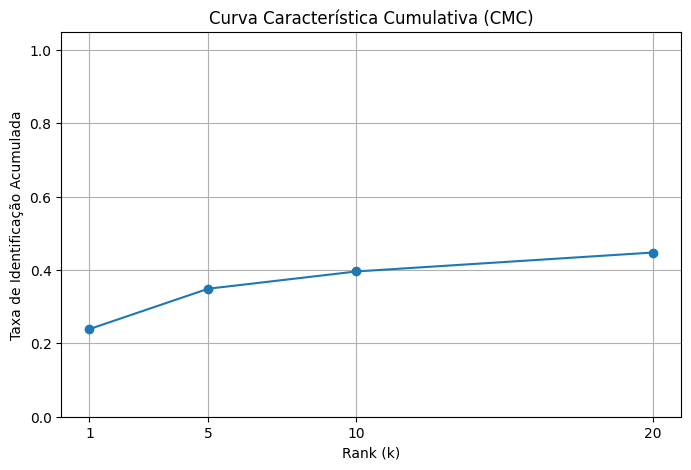


Métricas (TorchMetrics, baseadas em Rank-1, average='weighted'):
  Acurácia: 0.2390
  Precisão: 0.2432
  Recall:   0.2390
  F1-score: 0.2215
Matriz de confusão muito grande para plotar com anotações detalhadas.
Rank-1 Accuracy para o Fold 1: 23.90%
================== FOLD 2/5 ==================
Criando DataLoaders para o fold atual...
Inicializando novo modelo e otimizador...


/usr/local/lib/python3.11/dist-packages/facenet_pytorch/models/inception_resnet_v1.py:329: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(cached_file)

Epoch 1/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 1/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 1/15 | Treino Loss: 19.8888, Treino Acc: 0.0002 | Val Loss: 17.0548, Val Acc: 0.0055
  Novo melhor modelo encontrado! Val Loss: 17.0548. Salvando estado...


Epoch 2/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 2/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 2/15 | Treino Loss: 16.2912, Treino Acc: 0.0157 | Val Loss: 13.6858, Val Acc: 0.0721
  Novo melhor modelo encontrado! Val Loss: 13.6858. Salvando estado...


Epoch 3/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 3/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 3/15 | Treino Loss: 13.6114, Treino Acc: 0.0757 | Val Loss: 11.2561, Val Acc: 0.1893
  Novo melhor modelo encontrado! Val Loss: 11.2561. Salvando estado...


Epoch 4/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 4/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 4/15 | Treino Loss: 11.6849, Treino Acc: 0.1533 | Val Loss: 9.7802, Val Acc: 0.2848
  Novo melhor modelo encontrado! Val Loss: 9.7802. Salvando estado...


Epoch 5/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 5/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 5/15 | Treino Loss: 10.3645, Treino Acc: 0.2196 | Val Loss: 8.6890, Val Acc: 0.3640
  Novo melhor modelo encontrado! Val Loss: 8.6890. Salvando estado...


Epoch 6/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 6/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 6/15 | Treino Loss: 9.4236, Treino Acc: 0.2748 | Val Loss: 8.0974, Val Acc: 0.4139
  Novo melhor modelo encontrado! Val Loss: 8.0974. Salvando estado...


Epoch 7/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 7/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 7/15 | Treino Loss: 8.7005, Treino Acc: 0.3225 | Val Loss: 7.5846, Val Acc: 0.4624
  Novo melhor modelo encontrado! Val Loss: 7.5846. Salvando estado...


Epoch 8/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 8/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 8/15 | Treino Loss: 8.1172, Treino Acc: 0.3639 | Val Loss: 7.2294, Val Acc: 0.4939
  Novo melhor modelo encontrado! Val Loss: 7.2294. Salvando estado...


Epoch 9/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 9/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 9/15 | Treino Loss: 7.6350, Treino Acc: 0.3990 | Val Loss: 6.9365, Val Acc: 0.5214
  Novo melhor modelo encontrado! Val Loss: 6.9365. Salvando estado...


Epoch 10/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 10/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 10/15 | Treino Loss: 7.2347, Treino Acc: 0.4316 | Val Loss: 6.7252, Val Acc: 0.5433
  Novo melhor modelo encontrado! Val Loss: 6.7252. Salvando estado...


Epoch 11/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 11/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 11/15 | Treino Loss: 6.8670, Treino Acc: 0.4594 | Val Loss: 6.4942, Val Acc: 0.5694
  Novo melhor modelo encontrado! Val Loss: 6.4942. Salvando estado...


Epoch 12/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 12/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 12/15 | Treino Loss: 6.5576, Treino Acc: 0.4849 | Val Loss: 6.3277, Val Acc: 0.5811
  Novo melhor modelo encontrado! Val Loss: 6.3277. Salvando estado...


Epoch 13/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 13/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 13/15 | Treino Loss: 6.2863, Treino Acc: 0.5066 | Val Loss: 6.1885, Val Acc: 0.5953
  Novo melhor modelo encontrado! Val Loss: 6.1885. Salvando estado...


Epoch 14/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 14/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 14/15 | Treino Loss: 6.0147, Treino Acc: 0.5282 | Val Loss: 6.0655, Val Acc: 0.6096
  Novo melhor modelo encontrado! Val Loss: 6.0655. Salvando estado...


Epoch 15/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 15/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 15/15 | Treino Loss: 5.7820, Treino Acc: 0.5466 | Val Loss: 5.9124, Val Acc: 0.6228
  Novo melhor modelo encontrado! Val Loss: 5.9124. Salvando estado...

Tempo total de treinamento: 11909.417 segundos

Treinamento do Fold 2 concluído.
Melhor estado do modelo carregado para avaliação.
Salvando o state_dict do modelo fine-tuned em: models/best_model_fold_2.pth
Modelo salvo como best_model_fold_2.pth


Extraindo embeddings:   0%|          | 0/1885 [00:00<?, ?it/s]

Extraindo embeddings:   0%|          | 0/1889 [00:00<?, ?it/s]

Shape dos embeddings da galeria: (60294, 512)
Shape dos embeddings da probe: (60423, 512)
Iniciando avaliação em batches. Tamanho do batch de probes: 256


Processando batches de probes:   0%|          | 0/237 [00:00<?, ?it/s]

Processamento em batches concluído.
Rank-1 Accuracy: 22.85%
Rank-5 Accuracy: 34.29%
Rank-10 Accuracy: 39.13%
Rank-20 Accuracy: 44.43%


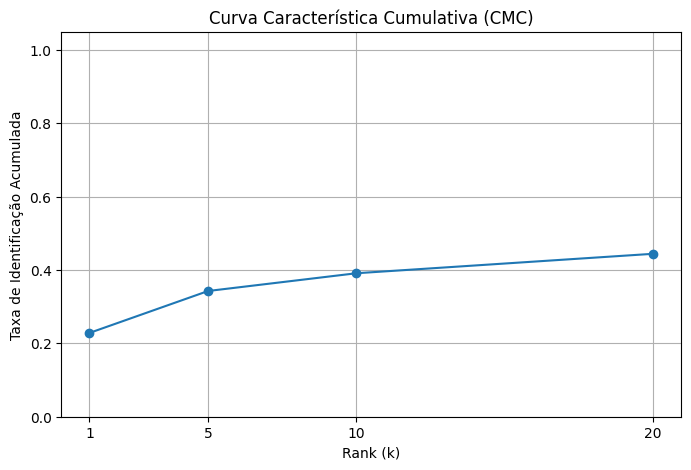


Métricas (TorchMetrics, baseadas em Rank-1, average='weighted'):
  Acurácia: 0.2285
  Precisão: 0.2346
  Recall:   0.2285
  F1-score: 0.2134
Matriz de confusão muito grande para plotar com anotações detalhadas.
Rank-1 Accuracy para o Fold 2: 22.85%
================== FOLD 3/5 ==================
Criando DataLoaders para o fold atual...
Inicializando novo modelo e otimizador...


/usr/local/lib/python3.11/dist-packages/facenet_pytorch/models/inception_resnet_v1.py:329: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(cached_file)

Epoch 1/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 1/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 1/15 | Treino Loss: 19.7712, Treino Acc: 0.0005 | Val Loss: 16.9033, Val Acc: 0.0088
  Novo melhor modelo encontrado! Val Loss: 16.9033. Salvando estado...


Epoch 2/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 2/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 2/15 | Treino Loss: 16.1365, Treino Acc: 0.0199 | Val Loss: 13.6200, Val Acc: 0.0777
  Novo melhor modelo encontrado! Val Loss: 13.6200. Salvando estado...


Epoch 3/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 3/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 3/15 | Treino Loss: 13.5019, Treino Acc: 0.0827 | Val Loss: 11.1484, Val Acc: 0.2045
  Novo melhor modelo encontrado! Val Loss: 11.1484. Salvando estado...


Epoch 4/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 4/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 4/15 | Treino Loss: 11.5976, Treino Acc: 0.1605 | Val Loss: 9.7054, Val Acc: 0.2944
  Novo melhor modelo encontrado! Val Loss: 9.7054. Salvando estado...


Epoch 5/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 5/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 5/15 | Treino Loss: 10.2868, Treino Acc: 0.2262 | Val Loss: 8.7724, Val Acc: 0.3650
  Novo melhor modelo encontrado! Val Loss: 8.7724. Salvando estado...


Epoch 6/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 6/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 6/15 | Treino Loss: 9.3461, Treino Acc: 0.2809 | Val Loss: 8.0988, Val Acc: 0.4213
  Novo melhor modelo encontrado! Val Loss: 8.0988. Salvando estado...


Epoch 7/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 7/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 7/15 | Treino Loss: 8.6250, Treino Acc: 0.3281 | Val Loss: 7.5823, Val Acc: 0.4671
  Novo melhor modelo encontrado! Val Loss: 7.5823. Salvando estado...


Epoch 8/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 8/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 8/15 | Treino Loss: 8.0395, Treino Acc: 0.3693 | Val Loss: 7.2620, Val Acc: 0.4982
  Novo melhor modelo encontrado! Val Loss: 7.2620. Salvando estado...


Epoch 9/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 9/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 9/15 | Treino Loss: 7.5470, Treino Acc: 0.4057 | Val Loss: 7.0183, Val Acc: 0.5210
  Novo melhor modelo encontrado! Val Loss: 7.0183. Salvando estado...


Epoch 10/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 10/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 10/15 | Treino Loss: 7.1651, Treino Acc: 0.4352 | Val Loss: 6.7424, Val Acc: 0.5493
  Novo melhor modelo encontrado! Val Loss: 6.7424. Salvando estado...


Epoch 11/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 11/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 11/15 | Treino Loss: 6.7893, Treino Acc: 0.4642 | Val Loss: 6.5312, Val Acc: 0.5674
  Novo melhor modelo encontrado! Val Loss: 6.5312. Salvando estado...


Epoch 12/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 12/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 12/15 | Treino Loss: 6.4906, Treino Acc: 0.4880 | Val Loss: 6.3206, Val Acc: 0.5898
  Novo melhor modelo encontrado! Val Loss: 6.3206. Salvando estado...


Epoch 13/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 13/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 13/15 | Treino Loss: 6.2016, Treino Acc: 0.5125 | Val Loss: 6.2498, Val Acc: 0.5937
  Novo melhor modelo encontrado! Val Loss: 6.2498. Salvando estado...


Epoch 14/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 14/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 14/15 | Treino Loss: 5.9627, Treino Acc: 0.5295 | Val Loss: 6.0394, Val Acc: 0.6170
  Novo melhor modelo encontrado! Val Loss: 6.0394. Salvando estado...


Epoch 15/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 15/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 15/15 | Treino Loss: 5.7161, Treino Acc: 0.5490 | Val Loss: 5.9503, Val Acc: 0.6237
  Novo melhor modelo encontrado! Val Loss: 5.9503. Salvando estado...

Tempo total de treinamento: 11960.203 segundos

Treinamento do Fold 3 concluído.
Melhor estado do modelo carregado para avaliação.
Salvando o state_dict do modelo fine-tuned em: models/best_model_fold_3.pth
Modelo salvo como best_model_fold_3.pth


Extraindo embeddings:   0%|          | 0/1885 [00:00<?, ?it/s]

Extraindo embeddings:   0%|          | 0/1889 [00:00<?, ?it/s]

Shape dos embeddings da galeria: (60294, 512)
Shape dos embeddings da probe: (60423, 512)
Iniciando avaliação em batches. Tamanho do batch de probes: 256


Processando batches de probes:   0%|          | 0/237 [00:00<?, ?it/s]

Processamento em batches concluído.
Rank-1 Accuracy: 23.07%
Rank-5 Accuracy: 34.05%
Rank-10 Accuracy: 39.06%
Rank-20 Accuracy: 44.53%


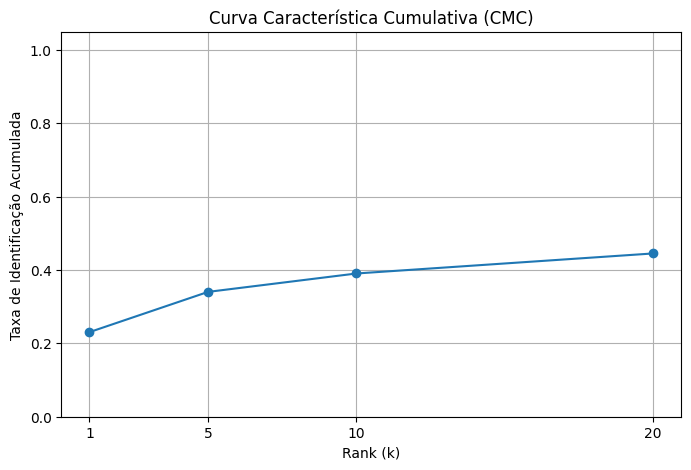


Métricas (TorchMetrics, baseadas em Rank-1, average='weighted'):
  Acurácia: 0.2307
  Precisão: 0.2338
  Recall:   0.2307
  F1-score: 0.2125
Matriz de confusão muito grande para plotar com anotações detalhadas.
Rank-1 Accuracy para o Fold 3: 23.07%
================== FOLD 4/5 ==================
Criando DataLoaders para o fold atual...
Inicializando novo modelo e otimizador...


/usr/local/lib/python3.11/dist-packages/facenet_pytorch/models/inception_resnet_v1.py:329: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(cached_file)

Epoch 1/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 1/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 1/15 | Treino Loss: 20.5222, Treino Acc: 0.0000 | Val Loss: 18.3129, Val Acc: 0.0000
  Novo melhor modelo encontrado! Val Loss: 18.3129. Salvando estado...


Epoch 2/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 2/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 2/15 | Treino Loss: 17.8527, Treino Acc: 0.0009 | Val Loss: 16.0868, Val Acc: 0.0066
  Novo melhor modelo encontrado! Val Loss: 16.0868. Salvando estado...


Epoch 3/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 3/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 3/15 | Treino Loss: 14.8993, Treino Acc: 0.0025 | Val Loss: 10.4958, Val Acc: 0.0000
  Novo melhor modelo encontrado! Val Loss: 10.4958. Salvando estado...


Epoch 4/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 4/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 4/15 | Treino Loss: 6.3882, Treino Acc: 0.8081 | Val Loss: 5.1008, Val Acc: 0.9998
  Novo melhor modelo encontrado! Val Loss: 5.1008. Salvando estado...


Epoch 5/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 5/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 5/15 | Treino Loss: 5.7323, Treino Acc: 0.9406 | Val Loss: 5.5208, Val Acc: 0.9491


Epoch 6/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 6/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 6/15 | Treino Loss: nan, Treino Acc: 0.2819 | Val Loss: nan, Val Acc: 0.0000


Epoch 7/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 7/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 7/15 | Treino Loss: nan, Treino Acc: 0.0000 | Val Loss: nan, Val Acc: 0.0000


Epoch 8/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 8/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 8/15 | Treino Loss: nan, Treino Acc: 0.0000 | Val Loss: nan, Val Acc: 0.0000


Epoch 9/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 9/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 9/15 | Treino Loss: nan, Treino Acc: 0.0000 | Val Loss: nan, Val Acc: 0.0000


Epoch 10/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 10/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 10/15 | Treino Loss: nan, Treino Acc: 0.0000 | Val Loss: nan, Val Acc: 0.0000


Epoch 11/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 11/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 11/15 | Treino Loss: nan, Treino Acc: 0.0000 | Val Loss: nan, Val Acc: 0.0000


Epoch 12/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 12/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 12/15 | Treino Loss: nan, Treino Acc: 0.0000 | Val Loss: nan, Val Acc: 0.0000


Epoch 13/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 13/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 13/15 | Treino Loss: nan, Treino Acc: 0.0000 | Val Loss: nan, Val Acc: 0.0000


Epoch 14/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 14/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 14/15 | Treino Loss: nan, Treino Acc: 0.0000 | Val Loss: nan, Val Acc: 0.0000
  Early stopping at epoch 14 as validation loss did not improve for 10 epoch.

Tempo total de treinamento: 11117.140 segundos

Treinamento do Fold 4 concluído.
Melhor estado do modelo carregado para avaliação.
Salvando o state_dict do modelo fine-tuned em: models/best_model_fold_4.pth
Modelo salvo como best_model_fold_4.pth


Extraindo embeddings:   0%|          | 0/1885 [00:00<?, ?it/s]

Extraindo embeddings:   0%|          | 0/1889 [00:00<?, ?it/s]

Shape dos embeddings da galeria: (60294, 512)
Shape dos embeddings da probe: (60423, 512)
Iniciando avaliação em batches. Tamanho do batch de probes: 256


Processando batches de probes:   0%|          | 0/237 [00:00<?, ?it/s]

Processamento em batches concluído.
Rank-1 Accuracy: 1.80%
Rank-5 Accuracy: 4.67%
Rank-10 Accuracy: 6.82%
Rank-20 Accuracy: 9.82%


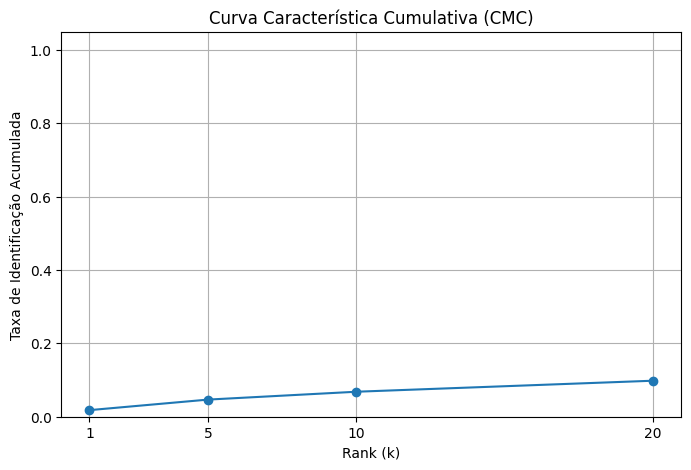


Métricas (TorchMetrics, baseadas em Rank-1, average='weighted'):
  Acurácia: 0.0180
  Precisão: 0.0253
  Recall:   0.0180
  F1-score: 0.0180
Matriz de confusão muito grande para plotar com anotações detalhadas.
Rank-1 Accuracy para o Fold 4: 1.80%
================== FOLD 5/5 ==================
Criando DataLoaders para o fold atual...
Inicializando novo modelo e otimizador...


/usr/local/lib/python3.11/dist-packages/facenet_pytorch/models/inception_resnet_v1.py:329: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(cached_file)

Epoch 1/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 1/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 1/15 | Treino Loss: 20.2114, Treino Acc: 0.0000 | Val Loss: 17.7203, Val Acc: 0.0010
  Novo melhor modelo encontrado! Val Loss: 17.7203. Salvando estado...


Epoch 2/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 2/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 2/15 | Treino Loss: 16.8489, Treino Acc: 0.0092 | Val Loss: 14.2989, Val Acc: 0.0466
  Novo melhor modelo encontrado! Val Loss: 14.2989. Salvando estado...


Epoch 3/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 3/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 3/15 | Treino Loss: 14.1716, Treino Acc: 0.0542 | Val Loss: 11.7588, Val Acc: 0.1581
  Novo melhor modelo encontrado! Val Loss: 11.7588. Salvando estado...


Epoch 4/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 4/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 4/15 | Treino Loss: 12.1272, Treino Acc: 0.1283 | Val Loss: 10.1141, Val Acc: 0.2609
  Novo melhor modelo encontrado! Val Loss: 10.1141. Salvando estado...


Epoch 5/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 5/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 5/15 | Treino Loss: 10.7125, Treino Acc: 0.1943 | Val Loss: 9.0016, Val Acc: 0.3383
  Novo melhor modelo encontrado! Val Loss: 9.0016. Salvando estado...


Epoch 6/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 6/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 6/15 | Treino Loss: 9.6870, Treino Acc: 0.2520 | Val Loss: 8.3506, Val Acc: 0.3955
  Novo melhor modelo encontrado! Val Loss: 8.3506. Salvando estado...


Epoch 7/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 7/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 7/15 | Treino Loss: 8.9334, Treino Acc: 0.3008 | Val Loss: 7.7717, Val Acc: 0.4413
  Novo melhor modelo encontrado! Val Loss: 7.7717. Salvando estado...


Epoch 8/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 8/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 8/15 | Treino Loss: 8.3254, Treino Acc: 0.3425 | Val Loss: 7.3371, Val Acc: 0.4792
  Novo melhor modelo encontrado! Val Loss: 7.3371. Salvando estado...


Epoch 9/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 9/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 9/15 | Treino Loss: 7.8211, Treino Acc: 0.3801 | Val Loss: 7.0560, Val Acc: 0.5118
  Novo melhor modelo encontrado! Val Loss: 7.0560. Salvando estado...


Epoch 10/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 10/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 10/15 | Treino Loss: 7.4020, Treino Acc: 0.4127 | Val Loss: 6.8240, Val Acc: 0.5317
  Novo melhor modelo encontrado! Val Loss: 6.8240. Salvando estado...


Epoch 11/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 11/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 11/15 | Treino Loss: 7.0226, Treino Acc: 0.4429 | Val Loss: 6.6012, Val Acc: 0.5540
  Novo melhor modelo encontrado! Val Loss: 6.6012. Salvando estado...


Epoch 12/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 12/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 12/15 | Treino Loss: 6.6823, Treino Acc: 0.4683 | Val Loss: 6.3771, Val Acc: 0.5750
  Novo melhor modelo encontrado! Val Loss: 6.3771. Salvando estado...


Epoch 13/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 13/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 13/15 | Treino Loss: 6.3922, Treino Acc: 0.4916 | Val Loss: 6.2658, Val Acc: 0.5871
  Novo melhor modelo encontrado! Val Loss: 6.2658. Salvando estado...


Epoch 14/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 14/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 14/15 | Treino Loss: 6.1423, Treino Acc: 0.5119 | Val Loss: 6.1100, Val Acc: 0.6031
  Novo melhor modelo encontrado! Val Loss: 6.1100. Salvando estado...


Epoch 15/15 [Treino]:   0%|          | 0/5523 [00:00<?, ?it/s]

Epoch 15/15 [Validação]:   0%|          | 0/1381 [00:00<?, ?it/s]

Epoch 15/15 | Treino Loss: 5.8971, Treino Acc: 0.5319 | Val Loss: 5.9608, Val Acc: 0.6126
  Novo melhor modelo encontrado! Val Loss: 5.9608. Salvando estado...

Tempo total de treinamento: 11997.629 segundos

Treinamento do Fold 5 concluído.
Melhor estado do modelo carregado para avaliação.
Salvando o state_dict do modelo fine-tuned em: models/best_model_fold_5.pth
Modelo salvo como best_model_fold_5.pth


Extraindo embeddings:   0%|          | 0/1885 [00:00<?, ?it/s]

Extraindo embeddings:   0%|          | 0/1889 [00:00<?, ?it/s]

Shape dos embeddings da galeria: (60294, 512)
Shape dos embeddings da probe: (60423, 512)
Iniciando avaliação em batches. Tamanho do batch de probes: 256


Processando batches de probes:   0%|          | 0/237 [00:00<?, ?it/s]

Processamento em batches concluído.
Rank-1 Accuracy: 23.66%
Rank-5 Accuracy: 34.91%
Rank-10 Accuracy: 39.96%
Rank-20 Accuracy: 45.07%


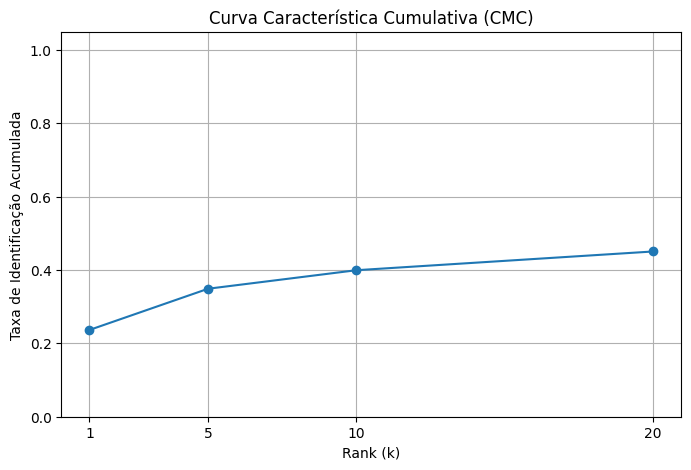


Métricas (TorchMetrics, baseadas em Rank-1, average='weighted'):
  Acurácia: 0.2366
  Precisão: 0.2409
  Recall:   0.2366
  F1-score: 0.2195
Matriz de confusão muito grande para plotar com anotações detalhadas.
Rank-1 Accuracy para o Fold 5: 23.66%


In [ ]:
BATCH_SIZE = 32

# Iniciar o loop de K-Fold
for fold, (train_indices, val_indices) in enumerate(skf.split(np.zeros(len(full_train_labels)), full_train_labels)):
  print(f"================== FOLD {fold + 1}/{K_FOLDS} ==================")

  # 1. Criando DataLoaders
  print("Criando DataLoaders para o fold atual...")

  # Criar samplers a partir dos índices gerados pelo KFold
  train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
  val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

  # Criação de Datasets
  train_dataset_fold = QMULImageDataset(root_dir=train_path, transform=train_transform, is_train_set=True)
  val_dataset_fold = QMULImageDataset(root_dir=train_path, transform=val_test_transform, is_train_set=True)

  # Criar os DataLoaders
  train_loader = DataLoader(train_dataset_fold,
                            batch_size=BATCH_SIZE,
                            sampler=train_sampler)

  val_loader = DataLoader(val_dataset_fold,
                          batch_size=BATCH_SIZE,
                          sampler=val_sampler)

  gallery_loader = DataLoader(gallery_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False)

  probe_loader = DataLoader(probe_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=False)

  # 2. Iniciando modelo, optimizer e loss
  print("Inicializando novo modelo e otimizador...")

  num_classes_train = len(full_train_dataset.class_names_original)

  arcface_model_fold = FaceRecognitionModelWithArcFace(num_classes=num_classes_train).to(device)

  optimizer = torch.optim.Adam(arcface_model_fold.parameters(),
                               lr=0.00005,
                               weight_decay=0.00001)

  loss_fn = nn.CrossEntropyLoss()

  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                         mode='min',
                                                         factor=0.1,
                                                         patience=3)

  # 3. Loop de treinamento
  # Variáveis para guardar o melhor modelo
  best_val_loss = float('inf')

  best_model_state = None

  patience_counter = 0

  early_stopping_patience = 10

  start_time_total_train = timer()

  for epoch in range(EPOCHS_PER_FOLD):
    # Fase de Treinamento
    arcface_model_fold.train()

    running_loss_train = 0.0
    running_acc_train = 0.0
    train_batches = 0

    loop_train = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{EPOCHS_PER_FOLD} [Treino]", leave=False)

    for images, labels, _ in loop_train:
      images, labels = images.to(device), labels.to(device)

      # 1. Forward pass com imagem e rótulo para o ArcFace
      outputs = arcface_model_fold(images, labels)

      # 2. Calcular a perda
      loss = loss_fn(outputs, labels)
      running_loss_train += loss.item()

      # 3. Zerar o gradiente do otimizador
      optimizer.zero_grad()

      # 4. Loss backward (Backpropagation)
      loss.backward()

      # 5. Step do otimizador
      optimizer.step()

      preds = torch.argmax(outputs, dim=1)

      running_acc_train += (preds == labels).float().mean().item() # Média da acurácia do batch

      train_batches +=1

      loop_train.set_postfix(loss=loss.item())

    avg_loss_train = running_loss_train / train_batches
    avg_acc_train = running_acc_train / train_batches

    # Fase de Validação
    arcface_model_fold.eval()

    running_loss_val = 0.0
    running_acc_val = 0.0
    val_batches = 0

    with torch.inference_mode():
      loop_val = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{EPOCHS_PER_FOLD} [Validação]", leave=False)

      for images, labels, _ in loop_val:
        images, labels = images.to(device), labels.to(device)

        # 1. Forward pass com imagem e rótulo
        outputs = arcface_model_fold(images, labels)

        # 2. Calcular a perda
        loss = loss_fn(outputs, labels)
        running_loss_val += loss.item()

        preds = torch.argmax(outputs, dim=1)

        running_acc_val += (preds == labels).float().mean().item()

        val_batches +=1

        loop_val.set_postfix(val_loss=loss.item())

    avg_loss_val = running_loss_val / val_batches
    avg_acc_val = running_acc_val / val_batches

    print(f"Epoch {epoch+1}/{EPOCHS_PER_FOLD} | Treino Loss: {avg_loss_train:.4f}, Treino Acc: {avg_acc_train:.4f} | "
          f"Val Loss: {avg_loss_val:.4f}, Val Acc: {avg_acc_val:.4f}")

    # Atualizar scheduler
    scheduler.step(avg_loss_val)

    # Salvar o melhor modelo e Early Stopping
    if avg_loss_val < best_val_loss:
      best_val_loss = avg_loss_val
      # Salvar uma cópia profunda do estado do modelo
      best_model_state = copy.deepcopy(arcface_model_fold.state_dict())
      patience_counter = 0
      print(f"  Novo melhor modelo encontrado! Val Loss: {best_val_loss:.4f}. Salvando estado...")
    else:
      patience_counter += 1

    if patience_counter >= early_stopping_patience:
      print(f"  Early stopping at epoch {epoch + 1} as validation loss did not improve for {early_stopping_patience} epoch.")
      break # Interromper o loop de treinamento

  end_time_total_train = timer()

  print(f"\nTempo total de treinamento: {end_time_total_train - start_time_total_train:.3f} segundos")

  print(f"\nTreinamento do Fold {fold+1} concluído.")

  # Se houver, carregar o melhor modelo salvo
  if best_model_state:
    arcface_model_fold.load_state_dict(best_model_state)
    print("Melhor estado do modelo carregado para avaliação.")

  # Salvando o modelo fine-tuned
  MODEL_PATH = Path("models")

  MODEL_PATH.mkdir(parents=True, exist_ok=True)

  MODEL_NAME = f'best_model_fold_{fold + 1}.pth'

  MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

  print(f"Salvando o state_dict do modelo fine-tuned em: {MODEL_SAVE_PATH}")

  torch.save(obj=arcface_model_fold.state_dict(), f=MODEL_SAVE_PATH)

  print(f"Modelo salvo como {MODEL_NAME}")

  # 4. Avaliar com o melhor modelo encontrado
  arcface_model_fold.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device, weights_only=True))

  # Extraindo o backbone
  model_for_eval = arcface_model_fold.backbone

  model_for_eval.eval()

  gallery_embeddings, gallery_labels, gallery_paths = extract_embeddings_fn(gallery_loader, model_for_eval, device)
  probe_embeddings, probe_labels, probe_paths = extract_embeddings_fn(probe_loader, model_for_eval, device)

  print(f"Shape dos embeddings da galeria: {gallery_embeddings.shape}")

  print(f"Shape dos embeddings da probe: {probe_embeddings.shape}")

  # Calcule as métricas de identificação
  rank_accuracies, error_log = evaluate_identification_metrics_batched(
      gallery_embeds=gallery_embeddings,
      gallery_lbls=gallery_labels,
      gallery_paths=gallery_paths,
      probe_embeds_full=probe_embeddings,
      probe_lbls_full=probe_labels,
      probe_paths_full=probe_paths,
      k_ranks=[1, 5, 10, 20],
      batch_size=256
  )

  # Guarde o resultado do Rank-1 para este fold
  rank1_accuracy = rank_accuracies[1]
  print(f"Rank-1 Accuracy para o Fold {fold+1}: {rank1_accuracy*100:.2f}%")
  results[f'fold_{fold+1}'] = rank1_accuracy

In [ ]:
print("\n================== RESULTADOS FINAIS DA VALIDAÇÃO CRUZADA ==================")

sum_accuracy = 0
for key, value in results.items():
  print(f"Acurácia para {key}: {value*100:.2f}%")
  sum_accuracy += value

mean_accuracy = sum_accuracy / len(results)
std_accuracy = np.std(list(results.values()))

print(f"\nPerformance Final (Média de {K_FOLDS} Folds):")
print(f"  - Rank-1 Accuracy Média: {mean_accuracy*100:.2f}%")
print(f"  - Desvio Padrão: {std_accuracy*100:.2f}%")


================== RESULTADOS FINAIS DA VALIDAÇÃO CRUZADA ==================
Acurácia para fold_1: 23.90%
Acurácia para fold_2: 22.85%
Acurácia para fold_3: 23.07%
Acurácia para fold_4: 1.80%
Acurácia para fold_5: 23.66%

Performance Final (Média de 5 Folds):
  - Rank-1 Accuracy Média: 19.06%
  - Desvio Padrão: 8.64%
